![DSME-logo](./img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# Comparing the abilities of TD(0) and constant-&alpha; MC

## Library Imports

In [18]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import custom_envs
import copy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Initializations

In this example, we compare the prediction abilities of TD(0) and constant-&alpha; MC. To do this, we use both methods for learning state value functions based on a given policy and compare how the deviation to the true state value function changes over the training episodes. For the comparison, we use Frozenlake, with a simple map of the form:

<img src="./img/env.png" alt="Environment" width="400" height="400" />

The agent's goal is to achieve the gift. Upon reaching the gift, the agent receives a reward of "1"; on any other space, the agent receives a reward of "0".


### Obtaining Policy and State Value Function

To compare the two methods, we first need a policy, as well as the associated value function. Here, we use policy iteration to determine both. Dynamic Programming is particularly suitable for determining the state value function that we use for reference, since it can determine it stably with adjustable accuracy, specified in `update_threshold`. The details of the implementation of the agent that performs the policy iteration are assumed to be given here. For more details on Dynamic Programming, we refer to previous lectures.


In [19]:

class MarkovDecisionProcess():
    def __init__(self, num_states, dynamics_fn):
        self.num_states = num_states
        self.actions_per_state = [] # list containing the actions available per state
        for state in dynamics_fn:
            actions = list(dynamics_fn[state].keys())
            self.actions_per_state.append(actions)
        self.P = dynamics_fn # P[s][a] represents a list of possible transitions and rewards given state s and a

class RandomWalkEnv(gym.Env, MarkovDecisionProcess):
    def __init__(self, p=0.9):
        # Gym spaces
        self.observation_space = spaces.Discrete(7)  # states 0-6
        self.action_space = spaces.Discrete(2)      # actions 0 (left) and 1 (right)

        # Initialize state
        self.state = 3  # start state
        self.start_state = 3
        self.terminal_states = {0, 6}

        # Define transition dynamics for MarkovDecisionProcess
        dynamics_fn = {}
        for s in range(1, 6):
            left_reward = 0 if s == 1 else 0
            right_reward = 1 if s == 5 else 0

            dynamics_fn[s] = {
                0: [  # left action
                    (1-p, s - 1, left_reward),
                    (p/2, s - 1, left_reward),
                    (p/2, s + 1, right_reward)
                ],
                1: [  # right action
                    (1-p, s + 1, right_reward),
                    (p/2, s - 1, left_reward),
                    (p/2, s + 1, right_reward)
                ]
            }

        # Terminal states
        dynamics_fn[0] = {0: [(1.0, 0, 0)], 1: [(1.0, 0, 0)]}
        dynamics_fn[6] = {0: [(1.0, 6, 0)], 1: [(1.0, 6, 0)]}

        # Initialize MarkovDecisionProcess parent
        MarkovDecisionProcess.__init__(self, num_states=7, dynamics_fn=dynamics_fn)

        self.p = p

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = self.start_state
        return self.state, {}

    def step(self, action):
        assert self.action_space.contains(action)

        # Get possible transitions for current state-action pair
        transitions = self.P[self.state][action]

        # Sample transition based on probabilities
        probs = [t[0] for t in transitions]
        next_states = [t[1] for t in transitions]
        rewards = [t[2] for t in transitions]

        idx = self.np_random.choice(len(transitions), p=probs)

        self.state = next_states[idx]
        reward = rewards[idx]
        terminated = self.state in self.terminal_states

        return self.state, reward, terminated, False, {}

    def render(self):
        pass  # Optional: implement if visualization is needed




class DP_Agent():
    def __init__(self, mdp, gamma=0.9, update_threshold=0.05):
        self.mdp = mdp # contains state transition function, num_states and actions
        self.update_threshold = update_threshold # stopping distance as criteria for stopping policy evaluation
        self.state_value_fn = np.zeros(self.mdp.num_states) # a table leading from state to value expectations
        self.policy = [[1 for _ in actions] for actions in self.mdp.actions_per_state]
        self.policy = [[action / len(actions) for action in actions] for actions in self.policy]
        self.gamma = gamma # discount rate for return

    def get_action(self, state):
        # Choose action based on the probabilities defined within the policy
        action = np.random.choice(np.flatnonzero(np.isclose(self.policy[state], max(self.policy[state]))))
        return action

    def get_action_value(self, state, action):
        # Calculate action value for state action pair based on the transition probabilities of the mdp
        action_value = 0
        for transition in self.mdp.P[state][action]:
            transition_prob = transition[0]  # prob of next state
            state_value_obs = transition[1]  # id of next state
            reward = transition[2]  # reward of next state
            action_value += transition_prob * (reward + self.gamma * self.state_value_fn[state_value_obs])
        return action_value

    def train(self):
        policy_stable = False
        while not policy_stable:
            # Use policy evaluation to update the value function
            self.policy_evaluation()
            # Use new value function to update the policy
            policy_stable = self.improve_policy() # if the policy stops changing, this ends the training process

    def policy_evaluation(self):
        # Policy evaluation for all states
        max_update = self.update_threshold + 1
        while max_update > self.update_threshold:
            max_update = 0
            for state in range(self.mdp.num_states):
                old_state_value = self.state_value_fn[state]
                new_state_value = 0
                actions = np.nonzero(self.policy[state])[0]
                for action in actions:
                    action_prob = self.policy[state][action]
                    new_state_value += action_prob * self.get_action_value(state, action)
                self.state_value_fn[state] = max(new_state_value, old_state_value)
                max_update = max(max_update, np.abs(old_state_value - self.state_value_fn[state]))

    def improve_policy(self):
        # Initiates improving the policy
        policy_stable = True
        # Cache current policy
        current_policy = self.policy
        # Create empty policy to store the best possible actions based on current value function
        best_policy = [[0 for _ in actions] for actions in self.mdp.actions_per_state]
        for state in range(self.mdp.num_states):
            # Calculate best possible policy based on current value function
            action_values = []
            for action in range(len(self.mdp.actions_per_state[state])):
                action_values.append(self.get_action_value(state, action))  # calculate q(s,a)
            action_value_max = max(action_values)
            best_actions = np.where(np.isclose(action_values, np.max(action_values), rtol=1e-9, atol=1e-9))[0]
            # find indices where maximum value occurs
            for index in best_actions:
                best_policy[state][index] = 1
            best_policy[state] = [best_policy[state][action] / len(best_actions)
                                  for action in self.mdp.actions_per_state[state]]
            # If the current policy is not the best policy, update it
            if not np.array_equal(current_policy[state], best_policy[state]):
                policy_stable = False
                self.policy[state] = best_policy[state]
        return policy_stable

    def visualize(self):
        print('State value function of the agent:')
        states = range(self.mdp.num_states)  # 7 states from 0 to 6

        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        plt.plot(states, self.state_value_fn, 'bo-')  # Plot state values as blue dots connected by lines

        # Add value labels above each point
        for state, value in enumerate(self.state_value_fn):
            ax.text(state, value + 0.02, f'{value:.3f}',
                    ha='center', va='bottom', fontsize=10)

        # Customize the plot
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xlabel('State')
        plt.ylabel('Value')
        plt.title('State Value Function')
        plt.xticks(states)
        plt.ylim(min(self.state_value_fn) - 0.1, max(self.state_value_fn) + 0.1)

        plt.show()


    def render_policy(self):
        print('Policy of the agent:')
        print('-----------------------------')
        out = ''
        for i in range(self.mdp.num_states):
            if i == 0 or i == 6:  # terminal states
                out += '■ '  # square for terminal state
            else:
                # Get the action probabilities for this state
                action_probs = self.policy[i]
                if action_probs[0] > action_probs[1]:
                    out += '← '  # left arrow if left action is preferred
                elif action_probs[1] > action_probs[0]:
                    out += '→ '  # right arrow if right action is preferred
                else:
                    out += '↔ '  # both arrows if equal probability
        print(out)


We now create the map, the environment and the agent, let the agent train until the optimal policy and the corresponding value function is found and then extract the state value function and policy. Under `target_state_value_fn` the state value function determined via DP now serves as a reference for TD(0) and constant-&alpha; MC.

In [20]:
# Set up map, environment, and agent
gamma = 0.9
mdp = RandomWalkEnv(p=1) # in our case contains dynamics function
agent = DP_Agent(mdp, update_threshold=1e-9, gamma=1)

# Train the agent.
agent.train()

# Extract the necessary functions for comparison
policy = agent.policy
target_state_value_fn = agent.state_value_fn

Below, we show both the state value function, and the resulting policy. The optimal policy in this environment always leads down-right and thus towards the gift. Since we use a discount factor &gamma; with the optimal policy, the state-value decreases from the terminal state to the initial state for each field by the factor &gamma;.

Policy of the agent:
-----------------------------
■ ↔ ↔ ↔ ↔ ↔ ■ 
State value function of the agent:


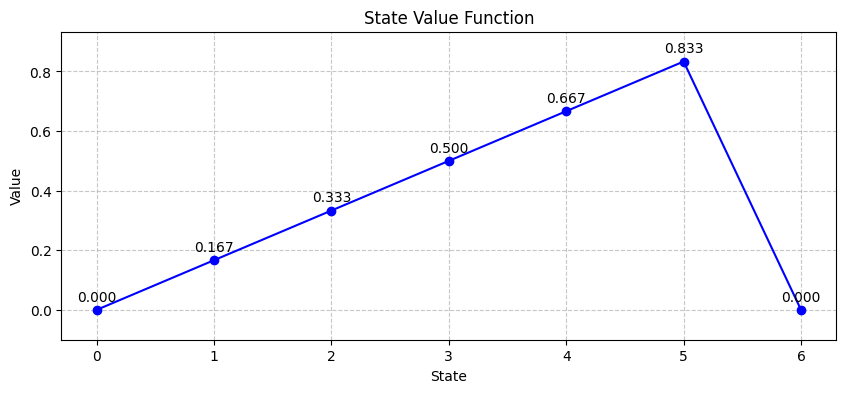

In [21]:
# Show the policy
agent.render_policy()

# Show the value function
agent.visualize()

Now that the policy and the target value function are ready, we can turn our attention to the methods for determining the state value function.

We implement the two methods in a way that returns a measure of the progress of learning for each episode. We use the root mean squared (RMS) error between the learned value function and the target value function. The methods return an array containing the RMS error of all learning episodes.

### Constant-&alpha; MC

With constant alpha MC, the update of the state value function is determined by comparing the return of a state with its current state value. In case there are deviations, the difference multiplied by the factor &alpha; is added to the state value.
Updates are always performed after the end of the episode for all passed states. In this implementation, updates are performed for every visit, whereby each visit is also a first visit due to the optimal policy.

In [22]:
def constant_alpha_MC(gamma, env, num_episodes, target_state_value_fn, policy):
    # Initialize lists to store returns for each state
    returns = {state: [] for state in range(mdp.num_states)}
    rms_errors = []

    for i_episode in range(1, num_episodes + 1):
        # Generate an episode using the policy
        episode = []
        obs, info = env.reset()
        done = False
        while not done:
            action = np.random.choice(len(policy[obs]), p=policy[obs])
            next_obs, reward, done, truncated, info = env.step(action)
            episode.append((obs, reward))
            obs = next_obs

        episode = np.array(episode)
        episode_duration = len(episode[:,:1])

        # Calculate returns for the whole episode
        G = np.zeros([episode_duration, ])
        for i in range(episode_duration - 1, -1, -1):
            if i + 1 > episode_duration - 1:
                G[i] = episode[i][1]  # Last step of the episode
            else:
                G[i] = episode[i][1] + gamma * G[i + 1]  # Every other step

        # Store returns for each state visited in the episode
        for index in range(episode_duration):
            state = int(episode[index][0])
            returns[state].append(G[index])

        # Calculate current state values as mean of all returns
        state_value_fn = np.zeros(mdp.num_states)
        for state in returns:
            if returns[state]:  # if state was visited at least once
                state_value_fn[state] = np.mean(returns[state])

        # Calculate root mean squared error for the episode
        rms_error = np.sqrt(np.mean(np.square(state_value_fn - target_state_value_fn)))
        rms_errors.append(rms_error)

    # Return both RMS errors and the final value estimate for state 3
    return rms_errors, np.mean(returns[3]) if returns[3] else 0.0


### TD(0)

In TD methods, the updates for the state value function are performed using the TD error. This error is the deviation between the state value of a state and the immediate reward, plus the discounted state value of the subsequent state. As with constant-&alpha; MC, in case of deviation, the error is added to the state value of a state with a factor alpha, however, not at the end of the episode but immediately. For TD(0), it is sufficient to observe a state, its reward, and subsequent state to determine the updates. The opposite of this behavior is TD(1), where the entire episode would be used for the error, so that updates could only be made at the end of the episode.

In [23]:
def td_0(gamma, alpha, env, num_episodes, target_state_value_fn, policy):
    # Initialize state value function
    state_value_fn = np.zeros(mdp.num_states)
    rms_errors = []
    trajectory = []
    for i in range(num_episodes):
        # Store trajectory for backward updates

        obs, info = env.reset()
        done = False

        # Collect trajectory
        while not done:
            action = np.random.choice(len(policy[obs]), p=policy[obs])
            next_obs, reward, done, truncated, info = env.step(action)
            trajectory.append((obs, action, reward, next_obs))
            obs = next_obs

        # Update value function backward
        for obs, action, reward, next_obs in reversed(trajectory):
            state_value_fn[obs] = state_value_fn[obs] + alpha * (
                    reward + (gamma * state_value_fn[next_obs]) - state_value_fn[obs]
            )

        # Calculate root mean squared error for the episode
        rms_error = np.sqrt(np.mean(np.square(state_value_fn - target_state_value_fn)))
        rms_errors.append(rms_error)

    return rms_errors, state_value_fn[3]


## Learning the State Value Functions

To obtain meaningful values, we perform the learning of the state value functions for both methods with multiple values of &alpha;. In addition, we use multiple runs for each value of &alpha; and average their values for the episodes using the `data_generator` method.

In [24]:
def data_generator(func, n_repeats, gamma, alpha, env, evaluation_episodes, target_state_value_fn, policy):
    data = []
    # Generate the data
    for i in range(n_repeats):
        data.append(func(gamma, alpha, env, evaluation_episodes, target_state_value_fn, policy))
    # Take the mean over the number of repeats
    mean_data = np.mean(data, axis=0)
    return mean_data

Now we use the `data_generator` to learn the state value functions for several values of &alpha; TD(0) and constant-&alpha; MC to get a plot of the mean RMS errors for each episode.

In [27]:
from tqdm import tqdm

num_episodes = [5, 10, 50, 150]
mc_values = []
td_values = []

for episodes in num_episodes:
    # Run TD(0)
    td_tmp = []
    mc_tmp = []
    for _ in tqdm(range(30)):
        _, td_val = td_0(gamma=1, alpha=0.1, env=env, num_episodes=episodes,
                         target_state_value_fn=target_state_value_fn, policy=policy)
        td_tmp.append(td_val)

        # Run Monte Carlo
        _, mc_val = constant_alpha_MC(gamma=1, env=env, num_episodes=episodes,
                                      target_state_value_fn=target_state_value_fn, policy=policy)
        mc_tmp.append(mc_val)
    mc_values.append(mc_tmp)
    td_values.append(td_tmp)


100%|██████████| 30/30 [00:02<00:00, 10.49it/s]


## Comparing the Results

Below we plot the RMS errors over the episodes. The dashed graphs represent constant-&alpha; MC, the solid ones represent TD(0). 
Both methods succeed in approximating the target value function, which is reflected in the reduction of the RMS error to almost zero.

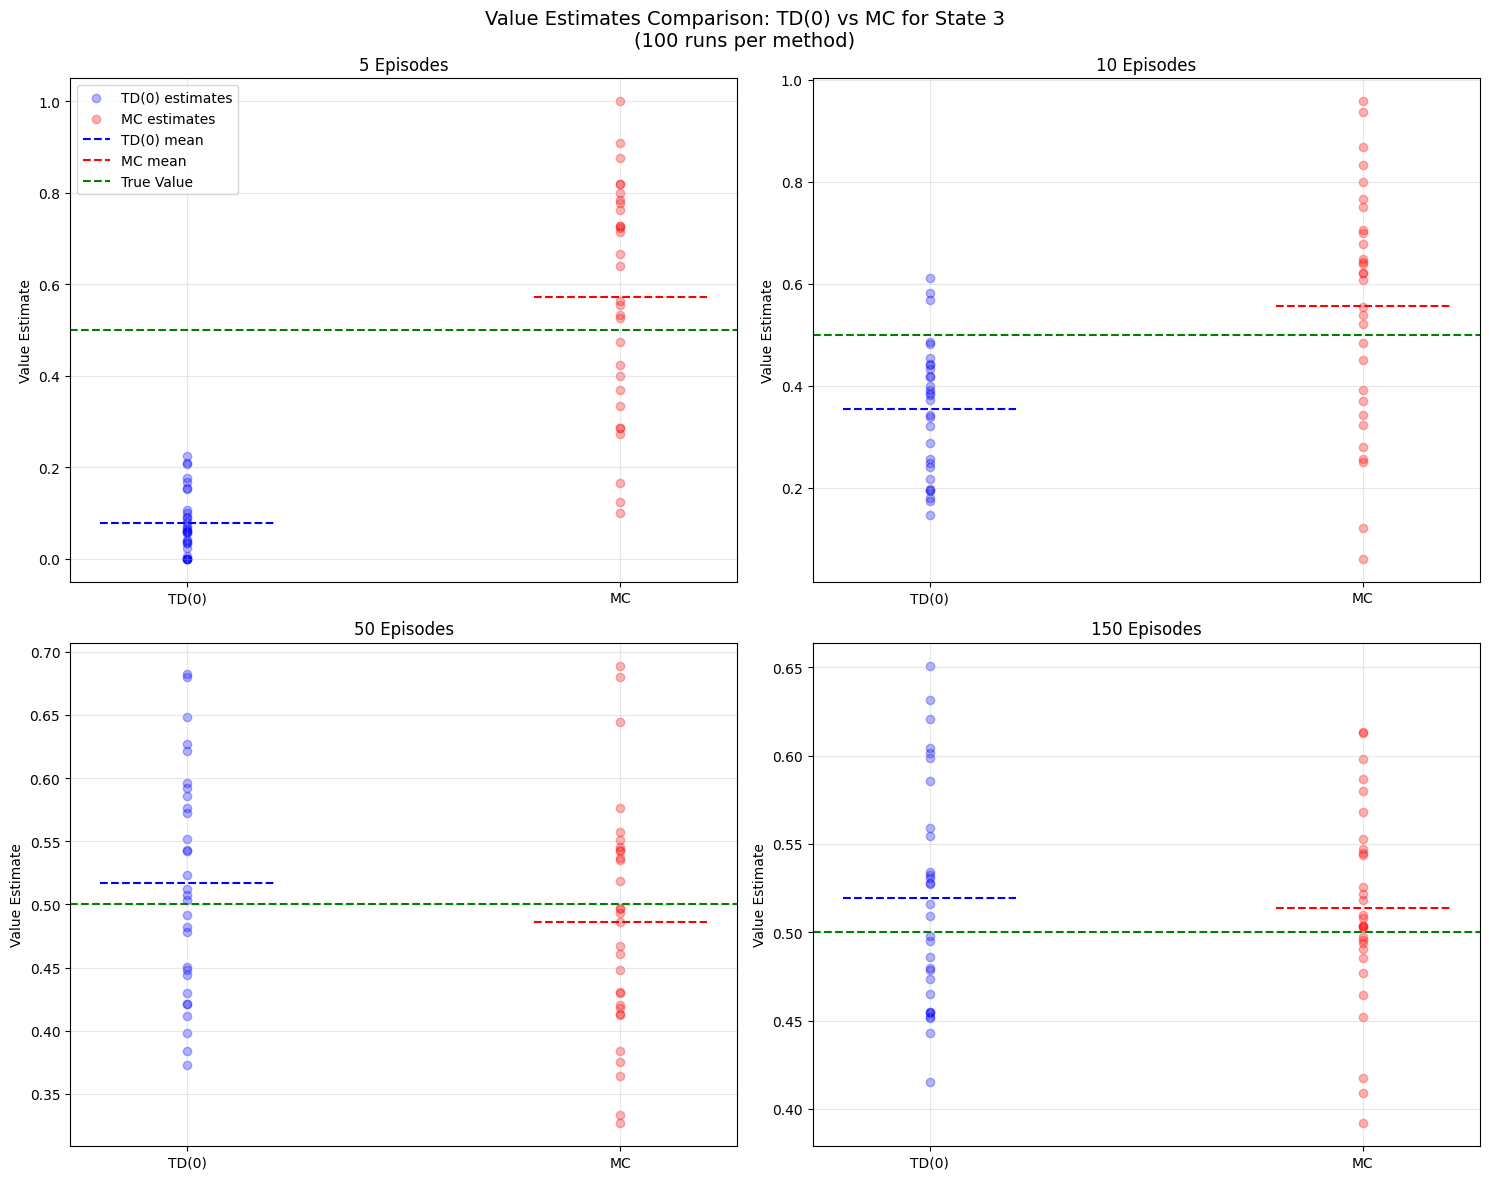

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Plot for each number of episodes
for idx, (episodes, td_vals, mc_vals) in enumerate(zip(num_episodes, td_values, mc_values)):
    # Convert to numpy arrays for easier manipulation
    td_array = np.array(td_vals)
    mc_array = np.array(mc_vals)

    # Calculate means
    td_mean = np.mean(td_array)
    mc_mean = np.mean(mc_array)

    # Create scatter plot of all estimates
    axes[idx].scatter(np.zeros_like(td_array), td_array, alpha=0.3, c='blue', label='TD(0) estimates')
    axes[idx].scatter(np.ones_like(mc_array), mc_array, alpha=0.3, c='red', label='MC estimates')

    # Plot means
    axes[idx].hlines(td_mean, -0.2, 0.2, colors='blue', linestyles='dashed', label='TD(0) mean')
    axes[idx].hlines(mc_mean, 0.8, 1.2, colors='red', linestyles='dashed', label='MC mean')

    # Plot true value
    axes[idx].axhline(y=target_state_value_fn[3], color='green', linestyle='--', label='True Value')

    # Customize subplot
    axes[idx].set_title(f'{episodes} Episodes')
    axes[idx].set_xticks([0, 1])
    axes[idx].set_xticklabels(['TD(0)', 'MC'])
    axes[idx].set_ylabel('Value Estimate')
    axes[idx].grid(True, alpha=0.3)

    if idx == 0:  # Only show legend for first subplot
        axes[idx].legend()

plt.suptitle('Value Estimates Comparison: TD(0) vs MC for State 3\n(100 runs per method)', fontsize=14)
plt.tight_layout()
plt.show()
